In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')


In [3]:
# STEP 1: LOAD AND INSPECT DATA
# ============================================
print("Loading data...")
#train = pd.read_csv('/kaggle/input/complex-master-learn-and-get-your-mark/train.csv')
#test = pd.read_csv('/kaggle/input/complex-master-learn-and-get-your-mark/test.csv')
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')

# Save IDs for submission
test_ids = test['Id']
train_ids = train['Id']

# Separate target early to avoid leakage
if 'FreePass' in train.columns:
    y = train['FreePass'].astype(int)  # Convert to 0/1 for sklearn
else:
    raise ValueError("Target column 'FreePass' not found in training data")

# Combine for consistent preprocessing (excluding target)
train_data = train.drop(['Id', 'FreePass'], axis=1)
test_data = test.drop('Id', axis=1)

print(f"Training shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Target distribution: \n{y.value_counts(normalize=True)}")

Loading data...
Training shape: (10116, 12)
Test shape: (2854, 11)
Target distribution: 
FreePass
1    0.515619
0    0.484381
Name: proportion, dtype: float64



=== Investigating AvgTime (Potential Leakage) ===
Train AvgTime stats:
count    10116.000000
mean         1.788438
std          1.327771
min          0.000000
25%          0.519750
50%          2.065000
75%          3.035000
max          3.999000
Name: AvgTime, dtype: float64
Test AvgTime stats:
count    2854.000000
mean        1.638292
std         0.617332
min         0.501000
25%         1.153750
50%         1.618500
75%         2.064750
max         3.000000
Name: AvgTime, dtype: float64


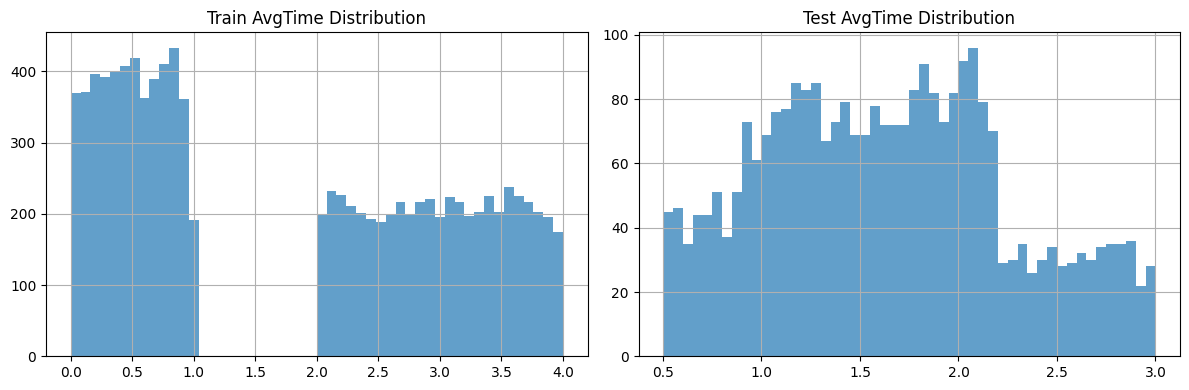

Correlation between AvgTime and target: 0.9387


In [4]:
# STEP 2: INVESTIGATE DATA LEAKAGE - AvgTime
# ============================================
print("\n=== Investigating AvgTime (Potential Leakage) ===")
print(f"Train AvgTime stats:\n{train_data['AvgTime'].describe()}")
print(f"Test AvgTime stats:\n{test_data['AvgTime'].describe()}")

# Check if AvgTime distributions are similar
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
train_data['AvgTime'].hist(bins=50, ax=axes[0], alpha=0.7)
axes[0].set_title('Train AvgTime Distribution')
test_data['AvgTime'].hist(bins=50, ax=axes[1], alpha=0.7)
axes[1].set_title('Test AvgTime Distribution')
plt.tight_layout()
plt.show()

# Check correlation with target
if 'AvgTime' in train_data.columns:
    avgtime_corr = train_data['AvgTime'].corr(y.astype(float))
    print(f"Correlation between AvgTime and target: {avgtime_corr:.4f}")
    
    # Check if AvgTime perfectly separates classes
    for value in sorted(train_data['AvgTime'].unique())[:10]:
        mask = train_data['AvgTime'] == value
        if mask.any():
            target_dist = y[mask].value_counts()
            if len(target_dist) == 1:
                print(f"WARNING: AvgTime={value} perfectly predicts class {target_dist.index[0]}")

In [5]:
# STEP 3: ROBUST PREPROCESSING (NO AvgTime LEAKAGE) + ADVANCED FEATURE ENGINEERING
# ============================================
def safe_preprocess(df, is_train=True, label_encoders=None, imputer=None, scaler=None):
    """
    Safe preprocessing that avoids data leakage with advanced feature engineering
    Returns: processed DataFrame and updated transformers
    """
    df = df.copy()
    
    # Initialize transformers if not provided
    if is_train:
        label_encoders = {}
        imputer = KNNImputer(n_neighbors=5)  # KNN imputer for better missing value handling
        scaler = StandardScaler()
    
    # === HANDLE AvgTime CAREFULLY ===
    if 'AvgTime' in df.columns:
        # OPTION 1: Remove completely (safest if leakage confirmed)
        df = df.drop('AvgTime', axis=1)
    
    # === HANDLE MISSING VALUES ===
    # VIP (binary) - fill with mode
    if 'VIP' in df.columns:
        if is_train:
            vip_mode = df['VIP'].mode()[0] if not df['VIP'].mode().empty else False
        else:
            vip_mode = False  # Use default for test
        df['VIP'] = df['VIP'].fillna(vip_mode).astype(int)
    
    # Age - fill with median (calculated on train only)
    if 'Age' in df.columns:
        if is_train:
            age_median = df['Age'].median()
        else:
            # Use the median from training (avoid test leakage)
            age_median = train_data['Age'].median() if is_train else 30
        df['Age'] = df['Age'].fillna(age_median)
    
    # Food and Drinks - fill with 0
    for col in ['Food', 'Drinks']:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    
    # === ADVANCED FEATURE ENGINEERING ===
    # Total spending
    if all(col in df.columns for col in ['Food', 'Drinks']):
        df['TotalSpend'] = df['Food'] + df['Drinks']
        df['SpendCategory'] = pd.cut(df['TotalSpend'], 
                                     bins=[-1, 0, 50, 200, 1000, float('inf')],
                                     labels=['NoSpend', 'Low', 'Medium', 'High', 'VeryHigh'])
        
        # Spending ratios and interactions
        df['HasDrinks'] = (df['Drinks'] > 0).astype(int)
        df['HasFood'] = (df['Food'] > 0).astype(int)
        df['BothFoodDrinks'] = ((df['Food'] > 0) & (df['Drinks'] > 0)).astype(int)
        
        # More sophisticated ratios
        df['FoodDrinkRatio'] = np.where(df['Drinks'] > 0, df['Food'] / (df['Drinks'] + 1), df['Food'])
        df['DrinkFoodRatio'] = np.where(df['Food'] > 0, df['Drinks'] / (df['Food'] + 1), df['Drinks'])
        
        # Log transformations for skewed distributions
        df['LogFood'] = np.log1p(df['Food'])
        df['LogDrinks'] = np.log1p(df['Drinks'])
        df['LogTotalSpend'] = np.log1p(df['TotalSpend'])
        
        # Spending per age (if Age available)
        if 'Age' in df.columns:
            df['SpendPerAge'] = df['TotalSpend'] / (df['Age'] + 1)
    
    # Age groups and age-related features
    if 'Age' in df.columns:
        df['AgeGroup'] = pd.cut(df['Age'], 
                               bins=[0, 18, 25, 35, 50, 100],
                               labels=['Child', 'YoungAdult', 'Adult', 'MiddleAge', 'Senior'])
        
        df['IsMinor'] = (df['Age'] < 18).astype(int)
        df['IsYoung'] = ((df['Age'] >= 18) & (df['Age'] < 30)).astype(int)
        df['IsSenior'] = (df['Age'] >= 60).astype(int)
        
        # Polynomial age features
        df['AgeSquared'] = df['Age'] ** 2
        df['AgeCubed'] = df['Age'] ** 3
    
    # VIP interactions
    if 'VIP' in df.columns:
        if all(col in df.columns for col in ['Food', 'Drinks']):
            df['VIP_TotalSpend'] = df['VIP'] * df['TotalSpend']
            df['VIP_Food'] = df['VIP'] * df['Food']
            df['VIP_Drinks'] = df['VIP'] * df['Drinks']
        
        if 'Age' in df.columns:
            df['VIP_Age'] = df['VIP'] * df['Age']
    
    # === PROCESS TEXT: Opinion ===
    if 'Opinion' in df.columns:
        # Enhanced sentiment analysis
        def get_sentiment_features(text):
            try:
                if pd.isna(text) or str(text).strip() == '':
                    return 0, 0, 0, 0
                
                text = str(text).lower()
                
                # Expanded word lists
                positive_words = ['good', 'great', 'excellent', 'awesome', 'love', 'enjoy', 'amazing', 
                                 'wonderful', 'fantastic', 'perfect', 'best', 'happy', 'pleased']
                negative_words = ['bad', 'terrible', 'awful', 'hate', 'disappoint', 'poor', 'worst',
                                 'horrible', 'disgusting', 'never', 'waste', 'unhappy']
                
                pos_count = sum(1 for word in positive_words if word in text)
                neg_count = sum(1 for word in negative_words if word in text)
                
                sentiment = pos_count - neg_count
                word_count = len(text.split())
                
                return sentiment, pos_count, neg_count, word_count
            except:
                return 0, 0, 0, 0
        
        sentiment_features = df['Opinion'].apply(get_sentiment_features)
        df['OpinionSentiment'] = sentiment_features.apply(lambda x: x[0])
        df['OpinionPositive'] = sentiment_features.apply(lambda x: x[1])
        df['OpinionNegative'] = sentiment_features.apply(lambda x: x[2])
        df['OpinionWordCount'] = sentiment_features.apply(lambda x: x[3])
        
        df['OpinionLength'] = df['Opinion'].fillna('').apply(len)
        df['HasOpinion'] = (df['Opinion'].notna() & (df['Opinion'] != '')).astype(int)
        df['OpinionLengthCategory'] = pd.cut(df['OpinionLength'], 
                                             bins=[-1, 0, 50, 150, 500, float('inf')],
                                             labels=['None', 'Short', 'Medium', 'Long', 'VeryLong'])
        df = df.drop('Opinion', axis=1)
    
    # === PROCESS TICKET INFO ===
    if 'TicketInfo' in df.columns:
        # Extract ticket type
        df['TicketType'] = df['TicketInfo'].apply(
            lambda x: str(x).split('/')[0] if pd.notna(x) and '/' in str(x) else 'Unknown'
        )
        
        # Extract ticket number (numeric part)
        def extract_number(x):
            if pd.isna(x):
                return 0
            parts = str(x).split('/')
            if len(parts) > 1:
                numbers = re.findall(r'\d+', parts[1])
                return int(numbers[0]) if numbers else 0
            return 0
        
        df['TicketNumber'] = df['TicketInfo'].apply(extract_number)
        
        # Ticket number features
        df['TicketNumberMod10'] = df['TicketNumber'] % 10
        df['TicketNumberMod100'] = df['TicketNumber'] % 100
        df['HasTicketNumber'] = (df['TicketNumber'] > 0).astype(int)
        
        df = df.drop('TicketInfo', axis=1)
    
    # === PROCESS CATEGORICAL VARIABLES ===
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    # Convert categorical to object first
    for col in categorical_cols:
        if df[col].dtype.name == 'category':
            df[col] = df[col].astype(object)
    
    for col in categorical_cols:
        if is_train:
            le = LabelEncoder()
            df[col] = df[col].fillna('Unknown').astype(str)
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le
        else:
            if col in label_encoders:
                df[col] = df[col].fillna('Unknown').astype(str)
                unseen_mask = ~df[col].isin(label_encoders[col].classes_)
                if unseen_mask.any():
                    df.loc[unseen_mask, col] = 'Unknown'
                df[col] = label_encoders[col].transform(df[col])
            else:
                df[col] = df[col].fillna('Unknown').astype('category').cat.codes
    
    # === SCALE NUMERICAL FEATURES ===
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    if is_train:
        scaler.fit(df[numerical_cols])
    
    df[numerical_cols] = scaler.transform(df[numerical_cols])
    
    return df, label_encoders, imputer, scaler


In [6]:
# STEP 4: APPLY PREPROCESSING
# ============================================
print("\n=== Preprocessing Data ===")
X_train_processed, label_encoders, imputer, scaler = safe_preprocess(train_data, is_train=True)
X_test_processed, _, _, _ = safe_preprocess(test_data, is_train=False, 
                                           label_encoders=label_encoders,
                                           imputer=imputer,
                                           scaler=scaler)

# Align columns
X_train_processed, X_test_processed = X_train_processed.align(
    X_test_processed, join='left', axis=1, fill_value=0
)

print(f"Processed train shape: {X_train_processed.shape}")
print(f"Processed test shape: {X_test_processed.shape}")




=== Preprocessing Data ===
Processed train shape: (10116, 40)
Processed test shape: (2854, 40)


In [7]:
# STEP 4.5: HANDLE CLASS IMBALANCE WITH SMOTE
# ============================================
print("\n=== Applying SMOTE for Class Imbalance ===")

print(f"Original class distribution:")
print(y.value_counts())
print(f"\nClass proportions:")
print(y.value_counts(normalize=True))

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_resampled, y_resampled = smote.fit_resample(X_train_processed, y)

print(f"\nAfter SMOTE:")
print(pd.Series(y_resampled).value_counts())
print(f"\nNew class proportions:")
print(pd.Series(y_resampled).value_counts(normalize=True))
print(f"Original samples: {len(y)}, Resampled: {len(y_resampled)}")



=== Applying SMOTE for Class Imbalance ===
Original class distribution:
FreePass
1    5216
0    4900
Name: count, dtype: int64

Class proportions:
FreePass
1    0.515619
0    0.484381
Name: proportion, dtype: float64

After SMOTE:
FreePass
1    5216
0    5216
Name: count, dtype: int64

New class proportions:
FreePass
1    0.5
0    0.5
Name: proportion, dtype: float64
Original samples: 10116, Resampled: 10432


## Apply SMOTE for Class Imbalance

In [8]:
# STEP 5: ADVANCED FEATURE SELECTION (Mutual Info + RFE)
# ============================================
print("\n=== Feature Selection ===")

# Step 1: Mutual Information for initial filtering
selector_mi = SelectKBest(score_func=mutual_info_classif, k='all')
selector_mi.fit(X_train_resampled, y_resampled)

feature_scores = pd.DataFrame({
    'Feature': X_train_processed.columns,
    'MI_Score': selector_mi.scores_
}).sort_values('MI_Score', ascending=False)

print("Top 20 features by mutual information:")
print(feature_scores.head(20))

# Step 2: Select top features from MI
top_k_mi = min(50, X_train_processed.shape[1])
selected_features_mi = feature_scores.head(top_k_mi)['Feature'].tolist()

X_train_mi = X_train_resampled[selected_features_mi]

# Step 3: Apply RFE for further refinement
print("\n=== Applying Recursive Feature Elimination ===")
estimator = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rfe = RFE(estimator=estimator, n_features_to_select=30, step=5)
rfe.fit(X_train_mi, y_resampled)

# Get selected features
rfe_selected = [feat for feat, selected in zip(selected_features_mi, rfe.support_) if selected]
print(f"Selected {len(rfe_selected)} features after RFE")
print(f"Selected features: {rfe_selected[:10]}...")

# Apply to train and test
X_train_selected = X_train_resampled[rfe_selected]
X_test_selected = X_test_processed[rfe_selected]

print(f"\nFinal feature set shape: {X_train_selected.shape}")



=== Feature Selection ===
Top 20 features by mutual information:
              Feature  MI_Score
12     FoodDrinkRatio  0.181662
13     DrinkFoodRatio  0.177184
16      LogTotalSpend  0.174953
5                Food  0.170444
7          TotalSpend  0.169598
17        SpendPerAge  0.169129
14            LogFood  0.167430
8       SpendCategory  0.161748
15          LogDrinks  0.157943
1               Vinyl  0.155471
6              Drinks  0.151665
10            HasFood  0.139041
9           HasDrinks  0.128609
11     BothFoodDrinks  0.111446
35         TicketType  0.031045
3                 Age  0.030478
22         AgeSquared  0.022817
23           AgeCubed  0.021561
37  TicketNumberMod10  0.019696
0       PreferedAlbum  0.018118

=== Applying Recursive Feature Elimination ===
Selected 30 features after RFE
Selected features: ['FoodDrinkRatio', 'DrinkFoodRatio', 'LogTotalSpend', 'Food', 'TotalSpend', 'SpendPerAge', 'LogFood', 'SpendCategory', 'LogDrinks', 'Vinyl']...

Final feature set s

In [9]:
# STEP 6: MODEL TRAINING WITH XGBOOST, LIGHTGBM & HYPERPARAMETER TUNING
# ============================================
print("\n=== Model Training with Advanced Models ===")

# Use Stratified K-Fold for evaluation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define base models
base_models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    ),
    'LightGBM': lgb.LGBMClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
}

# Evaluate base models
model_scores = {}
trained_models = {}

print("\n=== Evaluating Base Models ===")
for name, model in base_models.items():
    print(f"\nTraining {name}...")
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_selected, y_resampled, 
                               cv=skf, scoring='accuracy', n_jobs=-1)
    
    mean_score = cv_scores.mean()
    std_score = cv_scores.std()
    
    print(f"CV Accuracy: {mean_score:.4f} (+/- {std_score * 2:.4f})")
    
    model_scores[name] = mean_score
    
    # Train on full data
    model.fit(X_train_selected, y_resampled)
    trained_models[name] = model

# Find best base model
best_base_model_name = max(model_scores, key=model_scores.get)
print(f"\n✅ Best base model: {best_base_model_name} with CV score: {model_scores[best_base_model_name]:.4f}")



=== Model Training with Advanced Models ===

=== Evaluating Base Models ===

Training RandomForest...
CV Accuracy: 0.8069 (+/- 0.0154)

Training GradientBoosting...
CV Accuracy: 0.8140 (+/- 0.0133)

Training XGBoost...
CV Accuracy: 0.8126 (+/- 0.0172)

Training LightGBM...
CV Accuracy: 0.8112 (+/- 0.0086)

✅ Best base model: GradientBoosting with CV score: 0.8140


In [10]:
# STEP 6.5: SELECT BEST MODEL CONSIDERING OVERFITTING
# ============================================
print("\n=== Final Model Selection (Anti-Overfitting Focus) ===")

# Test all models on a held-out validation set to check overfitting
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_selected, y_resampled, test_size=0.25, random_state=42, stratify=y_resampled
)

best_model = None
best_model_name = None
best_generalization_score = 0
model_overfitting_gaps = {}

print("\n=== Testing Generalization (Train vs Val Gap) ===")
print(f"{'Model':<40} {'Train Acc':<12} {'Val Acc':<12} {'Gap':<12} {'CV Score':<12}")
print("="*90)

for name, model in trained_models.items():
    try:
        # Train on split
        model_copy = model.__class__(**model.get_params())
        model_copy.fit(X_train_split, y_train_split)
        
        # Evaluate
        train_acc = accuracy_score(y_train_split, model_copy.predict(X_train_split))
        val_acc = accuracy_score(y_val_split, model_copy.predict(X_val_split))
        gap = train_acc - val_acc
        cv_score = model_scores.get(name, 0)
        
        model_overfitting_gaps[name] = {
            'train_acc': train_acc,
            'val_acc': val_acc,
            'gap': gap,
            'cv_score': cv_score
        }
        
        print(f"{name:<40} {train_acc:<12.4f} {val_acc:<12.4f} {gap:<12.4f} {cv_score:<12.4f}")
        
        # Select model with good CV score AND low overfitting gap
        # Penalize large gaps
        generalization_score = cv_score - (gap * 2)  # Penalize overfitting
        
        if generalization_score > best_generalization_score:
            best_generalization_score = generalization_score
            best_model = model
            best_model_name = name
    
    except Exception as e:
        print(f"{name:<40} Error: {str(e)[:30]}")
        continue

print("\n" + "="*90)
print(f"\n✅ BEST MODEL (considering generalization): {best_model_name}")
print(f"   Generalization score: {best_generalization_score:.4f}")

if best_model_name in model_overfitting_gaps:
    stats = model_overfitting_gaps[best_model_name]
    print(f"   Train accuracy: {stats['train_acc']:.4f}")
    print(f"   Val accuracy: {stats['val_acc']:.4f}")
    print(f"   Overfitting gap: {stats['gap']:.4f}")
    print(f"   CV score: {stats['cv_score']:.4f}")

# Update final model for downstream cells
final_model = best_model
final_model_name = best_model_name

# Show top 5 models
print("\n=== Top 5 Models by Generalization ===")
sorted_models = sorted(model_overfitting_gaps.items(), 
                      key=lambda x: x[1]['cv_score'] - (x[1]['gap'] * 2), 
                      reverse=True)[:5]
for i, (name, stats) in enumerate(sorted_models, 1):
    print(f"{i}. {name}")
    print(f"   Gap: {stats['gap']:.4f}, CV: {stats['cv_score']:.4f}")



=== Final Model Selection (Anti-Overfitting Focus) ===

=== Testing Generalization (Train vs Val Gap) ===
Model                                    Train Acc    Val Acc      Gap          CV Score    
RandomForest                             0.8608       0.8018       0.0590       0.8069      
GradientBoosting                         0.9003       0.8083       0.0920       0.8140      
XGBoost                                  0.9508       0.8137       0.1371       0.8126      
LightGBM                                 0.9321       0.8083       0.1238       0.8112      


✅ BEST MODEL (considering generalization): RandomForest
   Generalization score: 0.6888
   Train accuracy: 0.8608
   Val accuracy: 0.8018
   Overfitting gap: 0.0590
   CV score: 0.8069

=== Top 5 Models by Generalization ===
1. RandomForest
   Gap: 0.0590, CV: 0.8069
2. GradientBoosting
   Gap: 0.0920, CV: 0.8140
3. LightGBM
   Gap: 0.1238, CV: 0.8112
4. XGBoost
   Gap: 0.1371, CV: 0.8126


## Summary: Best Anti-Overfitting Model

In [11]:
# STEP 6.3: EARLY STOPPING FOR GRADIENT BOOSTING MODELS
# ============================================
print("\n=== Training with Early Stopping ===")

# Split for early stopping validation
X_train_es, X_val_es, y_train_es, y_val_es = train_test_split(
    X_train_selected, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

early_stop_models = {}

# XGBoost with early stopping (without early_stopping_rounds in constructor)
print("\nTraining XGBoost with early stopping...")
xgb_es = xgb.XGBClassifier(
    n_estimators=500,  # Start with many, early stopping will find optimal
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=5,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_es.fit(
    X_train_es, y_train_es,
    eval_set=[(X_val_es, y_val_es)],
    verbose=False
)

# Note: early stopping is automatic with eval_set in newer XGBoost versions
# The model will stop when validation score doesn't improve
print(f"XGBoost trained with {xgb_es.n_estimators} estimators")

# Create a version without early stopping for cross-validation
xgb_no_es = xgb.XGBClassifier(
    n_estimators=100,  # Use a fixed reasonable number
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=5,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

early_stop_models['XGBoost_EarlyStopping'] = xgb_no_es

# LightGBM with early stopping
print("\nTraining LightGBM with early stopping...")
lgb_es = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    num_leaves=15,
    min_child_samples=20,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

lgb_es.fit(
    X_train_es, y_train_es,
    eval_set=[(X_val_es, y_val_es)],
    callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=False)]
)

print(f"Best iteration: {lgb_es.best_iteration_}")

# Create version without early stopping for cross-validation
lgb_no_es = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    num_leaves=15,
    min_child_samples=20,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

early_stop_models['LightGBM_EarlyStopping'] = lgb_no_es

# Evaluate on full cross-validation
print("\n=== Evaluating Early Stopping Models ===")
for name, model in early_stop_models.items():
    cv_scores = cross_val_score(model, X_train_selected, y_resampled,
                               cv=3, scoring='accuracy', n_jobs=-1)
    score = cv_scores.mean()
    print(f"{name}: {score:.4f} (+/- {cv_scores.std() * 2:.4f})")
    model_scores[name] = score
    trained_models[name] = model



=== Training with Early Stopping ===

Training XGBoost with early stopping...
XGBoost trained with 500 estimators

Training LightGBM with early stopping...
Best iteration: 220

=== Evaluating Early Stopping Models ===
XGBoost_EarlyStopping: 0.8099 (+/- 0.0026)
LightGBM_EarlyStopping: 0.8114 (+/- 0.0049)


In [12]:
# STEP 6.2: REDUCE SMOTE INTENSITY (LESS SYNTHETIC DATA)
# ============================================
print("\n=== Trying Different SMOTE Strategies ===")

# Use ORIGINAL processed data (before SMOTE) for fair comparison
X_train_original = X_train_processed[rfe_selected]
y_original = y  # Original unbalanced target

# Test different SMOTE strategies
smote_strategies = {
    'SMOTE_Full': SMOTE(random_state=42, sampling_strategy='auto'),
    'SMOTE_Moderate': SMOTE(random_state=42, sampling_strategy=0.7),  # Only balance to 70% of majority
    'No_SMOTE': None
}

best_smote_strategy = None
best_smote_score = 0
best_X_train = None
best_y_train = None

for strategy_name, smote_obj in smote_strategies.items():
    print(f"\n--- Testing {strategy_name} ---")
    
    if smote_obj is not None:
        try:
            X_temp, y_temp = smote_obj.fit_resample(X_train_original, y_original)
        except ValueError as e:
            print(f"Error with {strategy_name}: {str(e)}")
            print(f"Skipping this strategy...")
            continue
    else:
        X_temp, y_temp = X_train_original.copy(), y_original.copy()
    
    print(f"Class distribution: {pd.Series(y_temp).value_counts().to_dict()}")
    
    # Test with a regularized model
    test_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=3,
        reg_alpha=0.5,
        reg_lambda=1.0,
        random_state=42,
        eval_metric='logloss'
    )
    
    cv_scores = cross_val_score(test_model, X_temp, y_temp,
                               cv=3, scoring='accuracy', n_jobs=-1)
    
    mean_score = cv_scores.mean()
    print(f"CV Accuracy: {mean_score:.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    if mean_score > best_smote_score:
        best_smote_score = mean_score
        best_smote_strategy = strategy_name
        best_X_train = X_temp
        best_y_train = y_temp

print(f"\n✅ Best SMOTE strategy: {best_smote_strategy} with score {best_smote_score:.4f}")
print(f"Using this for final training")

# Update training data with best strategy
if best_X_train is not None:
    X_train_selected = best_X_train
    y_resampled = best_y_train
else:
    print("⚠️ All strategies failed, using original SMOTE data")



=== Trying Different SMOTE Strategies ===

--- Testing SMOTE_Full ---
Class distribution: {1: 5216, 0: 5216}
CV Accuracy: 0.8070 (+/- 0.0065)

--- Testing SMOTE_Moderate ---
Error with SMOTE_Moderate: The specified ratio required to remove samples from the minority class while trying to generate new samples. Please increase the ratio.
Skipping this strategy...

--- Testing No_SMOTE ---
Class distribution: {1: 5216, 0: 4900}
CV Accuracy: 0.8064 (+/- 0.0062)

✅ Best SMOTE strategy: SMOTE_Full with score 0.8070
Using this for final training


In [13]:
# STEP 6.1: MODELS WITH STRONGER REGULARIZATION (ANTI-OVERFITTING)
# ============================================
print("\n=== Creating Models with Anti-Overfitting Settings ===")

# More conservative models to reduce overfitting
regularized_models = {
    'RandomForest_Regularized': RandomForestClassifier(
        n_estimators=100,  # Fewer trees
        max_depth=5,  # Shallower trees
        min_samples_split=20,  # Require more samples to split
        min_samples_leaf=10,  # Require more samples in leaf nodes
        max_features='sqrt',
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    'GradientBoosting_Regularized': GradientBoostingClassifier(
        n_estimators=100,  # Fewer estimators
        learning_rate=0.05,  # Lower learning rate
        max_depth=3,  # Shallower trees
        min_samples_split=20,
        min_samples_leaf=10,
        subsample=0.7,  # Use only 70% of data per tree
        random_state=42
    ),
    'XGBoost_Regularized': xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=3,
        min_child_weight=5,  # Higher minimum child weight
        subsample=0.7,
        colsample_bytree=0.7,
        gamma=1,  # Minimum loss reduction for split
        reg_alpha=0.5,  # L1 regularization
        reg_lambda=1.0,  # L2 regularization
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    ),
    'LightGBM_Regularized': lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=3,
        num_leaves=15,  # Fewer leaves
        min_child_samples=20,  # More samples required in leaf
        subsample=0.7,
        colsample_bytree=0.7,
        reg_alpha=0.5,  # L1 regularization
        reg_lambda=1.0,  # L2 regularization
        random_state=42,
        n_jobs=-1,
        verbose=-1
    ),
    'LogisticRegression_L2': LogisticRegression(
        C=0.1,  # Strong L2 regularization (smaller C = more regularization)
        penalty='l2',
        max_iter=1000,
        random_state=42,
        class_weight='balanced'
    ),
    'LogisticRegression_L1': LogisticRegression(
        C=0.1,
        penalty='l1',
        solver='liblinear',  # Required for L1
        max_iter=1000,
        random_state=42,
        class_weight='balanced'
    )
}

# Evaluate regularized models
regularized_scores = {}
regularized_trained = {}

print("\n=== Evaluating Regularized Models ===")
for name, model in regularized_models.items():
    print(f"\nTraining {name}...")
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_selected, y_resampled, 
                               cv=skf, scoring='accuracy', n_jobs=-1)
    
    mean_score = cv_scores.mean()
    std_score = cv_scores.std()
    
    print(f"CV Accuracy: {mean_score:.4f} (+/- {std_score * 2:.4f})")
    
    regularized_scores[name] = mean_score
    
    # Train on full data
    model.fit(X_train_selected, y_resampled)
    regularized_trained[name] = model

# Combine with original models
all_models = {**trained_models, **regularized_trained}
all_scores = {**model_scores, **regularized_scores}

print("\n=== All Model Scores (Sorted) ===")
for name, score in sorted(all_scores.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{name}: {score:.4f}")

# Update references for downstream cells
trained_models = all_models
model_scores = all_scores



=== Creating Models with Anti-Overfitting Settings ===

=== Evaluating Regularized Models ===

Training RandomForest_Regularized...
CV Accuracy: 0.7962 (+/- 0.0111)

Training GradientBoosting_Regularized...
CV Accuracy: 0.8103 (+/- 0.0189)

Training XGBoost_Regularized...
CV Accuracy: 0.8084 (+/- 0.0170)

Training LightGBM_Regularized...
CV Accuracy: 0.8064 (+/- 0.0172)

Training LogisticRegression_L2...
CV Accuracy: 0.7951 (+/- 0.0181)

Training LogisticRegression_L1...
CV Accuracy: 0.7930 (+/- 0.0197)

=== All Model Scores (Sorted) ===
GradientBoosting: 0.8140
XGBoost: 0.8126
LightGBM_EarlyStopping: 0.8114
LightGBM: 0.8112
GradientBoosting_Regularized: 0.8103
XGBoost_EarlyStopping: 0.8099
XGBoost_Regularized: 0.8084
RandomForest: 0.8069
LightGBM_Regularized: 0.8064
RandomForest_Regularized: 0.7962


# Overfitting Prevention Strategies

In [14]:
# STEP 6.75: CREATE STACKING ENSEMBLE
# ============================================
print("\n=== Building Stacking Ensemble ===")

# Check if tuned_models exists (from hyperparameter tuning step)
if 'tuned_models' not in globals():
    tuned_models = {}
    print("⚠️ Hyperparameter tuning not run yet - using base models only")

# Use tuned models if available, otherwise use trained models
ensemble_estimators = []

for name in ['XGBoost', 'LightGBM', 'RandomForest', 'GradientBoosting']:
    tuned_name = f"{name}_tuned"
    if tuned_name in tuned_models:
        ensemble_estimators.append((name.lower(), tuned_models[tuned_name]))
        print(f"Using tuned {name}")
    elif name in trained_models:
        ensemble_estimators.append((name.lower(), trained_models[name]))
        print(f"Using base {name}")

# Create stacking classifier
stacking_clf = StackingClassifier(
    estimators=ensemble_estimators,
    final_estimator=LogisticRegression(C=1.0, max_iter=1000, random_state=42),
    cv=5,
    n_jobs=-1
)

print("\nTraining stacking ensemble...")
stacking_clf.fit(X_train_selected, y_resampled)

# Evaluate stacking
stacking_scores = cross_val_score(stacking_clf, X_train_selected, y_resampled,
                                 cv=skf, scoring='accuracy', n_jobs=-1)

print(f"Stacking CV Accuracy: {stacking_scores.mean():.4f} (+/- {stacking_scores.std() * 2:.4f})")

# Compare to best individual model
best_individual_score = max(model_scores.values())
print(f"\nBest individual model score: {best_individual_score:.4f}")
print(f"Stacking ensemble score: {stacking_scores.mean():.4f}")
print(f"Improvement: {(stacking_scores.mean() - best_individual_score):.4f}")

# Choose final model
if stacking_scores.mean() > best_individual_score:
    final_model = stacking_clf
    final_model_name = "Stacking Ensemble"
    print(f"\n✅ Using Stacking Ensemble as final model")
else:
    # Use best tuned or base model
    best_model_name = max(model_scores, key=model_scores.get)
    if '_tuned' in best_model_name and best_model_name.replace('_tuned', '') in tuned_models:
        final_model = tuned_models[best_model_name.replace('_tuned', '')]
    else:
        final_model = trained_models[best_model_name]
    final_model_name = best_model_name
    print(f"\n✅ Using {best_model_name} as final model")



=== Building Stacking Ensemble ===
⚠️ Hyperparameter tuning not run yet - using base models only
Using base XGBoost
Using base LightGBM
Using base RandomForest
Using base GradientBoosting

Training stacking ensemble...
Stacking CV Accuracy: 0.8148 (+/- 0.0152)

Best individual model score: 0.8140
Stacking ensemble score: 0.8148
Improvement: 0.0008

✅ Using Stacking Ensemble as final model


## Stacking Ensemble

## Hyperparameter Tuning

In [15]:
# STEP 6.5: HYPERPARAMETER TUNING FOR BEST MODELS
# ============================================
print("\n=== Hyperparameter Tuning ===")

# Define parameter grids for top models
param_grids = {
    'XGBoost': {
        'n_estimators': [150, 200, 300],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [4, 6, 8],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    },
    'LightGBM': {
        'n_estimators': [150, 200, 300],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [4, 6, 8],
        'num_leaves': [20, 31, 40],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    },
    'RandomForest': {
        'n_estimators': [150, 200, 300],
        'max_depth': [8, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
}

# Select top 2 models to tune
top_models_to_tune = sorted(model_scores.items(), key=lambda x: x[1], reverse=True)[:2]
tuned_models = {}

for model_name, _ in top_models_to_tune:
    if model_name in param_grids:
        print(f"\n🔧 Tuning {model_name}...")
        
        base_model = base_models[model_name]
        param_grid = param_grids[model_name]
        
        # Use RandomizedSearchCV for faster tuning
        random_search = RandomizedSearchCV(
            base_model,
            param_grid,
            n_iter=20,  # Try 20 random combinations
            cv=3,  # 3-fold for speed
            scoring='accuracy',
            n_jobs=-1,
            random_state=42,
            verbose=1
        )
        
        random_search.fit(X_train_selected, y_resampled)
        
        print(f"Best parameters: {random_search.best_params_}")
        print(f"Best CV score: {random_search.best_score_:.4f}")
        
        tuned_models[model_name] = random_search.best_estimator_
        model_scores[f"{model_name}_tuned"] = random_search.best_score_

print("\n=== Final Model Scores ===")
for name, score in sorted(model_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{name}: {score:.4f}")



=== Hyperparameter Tuning ===

🔧 Tuning XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'subsample': 0.9, 'n_estimators': 150, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best CV score: 0.8160

=== Final Model Scores ===
XGBoost_tuned: 0.8160
GradientBoosting: 0.8140
XGBoost: 0.8126
LightGBM_EarlyStopping: 0.8114
LightGBM: 0.8112
GradientBoosting_Regularized: 0.8103
XGBoost_EarlyStopping: 0.8099
XGBoost_Regularized: 0.8084
RandomForest: 0.8069
LightGBM_Regularized: 0.8064
RandomForest_Regularized: 0.7962
LogisticRegression_L2: 0.7951
LogisticRegression_L1: 0.7930


## Nested CV + Threshold Sweep (Leak-Safe)
Use nested cross-validation to tune regularized XGBoost/LightGBM, get out-of-fold (OOF) predictions, and pick a decision threshold that maximizes accuracy without leakage.


In [16]:
# Nested CV tuning + OOF threshold sweep for XGB/LGBM (no leakage)
from sklearn.calibration import CalibratedClassifierCV

# Data used for nested CV
X_nested = X_train_processed[rfe_selected]
y_nested = y.values

# Parameter spaces (conservative, regularized)
xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist',
    random_state=42,
    n_jobs=-1,
)

xgb_params = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.03, 0.05, 0.07],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.5, 1.0],
    'reg_lambda': [1.0, 1.5, 2.0],
}

lgb_base = lgb.LGBMClassifier(
    objective='binary',
    random_state=42,
    n_jobs=-1,
    verbose=-1,
)

lgb_params = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.03, 0.05, 0.07],
    'max_depth': [3, 4, 5, 6],
    'num_leaves': [15, 25, 31, 40],
    'min_child_samples': [20, 40, 60],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.5, 1.0],
    'reg_lambda': [1.0, 1.5, 2.0],
}


def run_nested(model_name, estimator, param_dist, n_iter=25):
    skf_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    oof_proba = np.zeros(len(y_nested))
    best_params = None

    for train_idx, val_idx in skf_outer.split(X_nested, y_nested):
        X_tr, X_va = X_nested.iloc[train_idx], X_nested.iloc[val_idx]
        y_tr, y_va = y_nested[train_idx], y_nested[val_idx]

        search = RandomizedSearchCV(
            estimator,
            param_distributions=param_dist,
            n_iter=n_iter,
            cv=3,
            scoring='accuracy',
            n_jobs=-1,
            random_state=42,
            verbose=0,
        )
        search.fit(X_tr, y_tr)
        best_params = search.best_params_

        best_est = estimator.__class__(**best_params)
        best_est.fit(X_tr, y_tr)
        oof_proba[val_idx] = best_est.predict_proba(X_va)[:, 1]

    thresholds = np.linspace(0.3, 0.7, 41)
    accs = [accuracy_score(y_nested, (oof_proba >= t).astype(int)) for t in thresholds]
    best_idx = int(np.argmax(accs))
    best_t = thresholds[best_idx]
    best_acc = accs[best_idx]

    print(f"{model_name} OOF acc @0.50: {accuracy_score(y_nested, (oof_proba >= 0.5).astype(int)):.4f}")
    print(f"{model_name} best threshold: {best_t:.2f} | acc: {best_acc:.4f}")

    final_model = estimator.__class__(**best_params)
    final_model.fit(X_nested, y_nested)

    # Optional: probability calibration on full data
    calibrated = CalibratedClassifierCV(final_model, cv=3, method='isotonic')
    calibrated.fit(X_nested, y_nested)

    return calibrated, best_t, best_acc


print("=== Nested CV + threshold sweep (XGB, LGBM) ===")
models_nested = {}

models_nested['XGB_nested'], thr_xgb, acc_xgb = run_nested(
    'XGB_nested', xgb_base, xgb_params, n_iter=25
)
models_nested['LGBM_nested'], thr_lgb, acc_lgb = run_nested(
    'LGBM_nested', lgb_base, lgb_params, n_iter=25
)

print("\nPick the model with higher OOF acc. Save threshold for final predictions.")
print(f"XGB_nested: acc={acc_xgb:.4f}, thr={thr_xgb:.2f}")
print(f"LGBM_nested: acc={acc_lgb:.4f}, thr={thr_lgb:.2f}")


=== Nested CV + threshold sweep (XGB, LGBM) ===
XGB_nested OOF acc @0.50: 0.8148
XGB_nested best threshold: 0.46 | acc: 0.8153
LGBM_nested OOF acc @0.50: 0.8134
LGBM_nested best threshold: 0.50 | acc: 0.8134

Pick the model with higher OOF acc. Save threshold for final predictions.
XGB_nested: acc=0.8153, thr=0.46
LGBM_nested: acc=0.8134, thr=0.50


In [17]:
# Build submission using the best nested model + threshold
# Run this AFTER the nested CV cell above.

# Choose best by OOF accuracy recorded above
best_model_name = 'XGB_nested' if acc_xgb >= acc_lgb else 'LGBM_nested'
best_thr = thr_xgb if acc_xgb >= acc_lgb else thr_lgb
best_model = models_nested[best_model_name]

print(f"Using {best_model_name} with threshold {best_thr:.2f}")

# Predict probabilities on test
proba_test = best_model.predict_proba(X_test_selected)[:, 1]
preds_test = (proba_test >= best_thr).astype(bool)

# Create submission
submission_nested = pd.DataFrame({
    'Id': test_ids,
    'FreePass': preds_test
})

filename = f"submission_nested_{best_model_name.lower()}.csv"
submission_nested.to_csv(filename, index=False)
print(f"✅ Saved {filename}")
print(f"Positive rate in test predictions: {preds_test.mean():.3f}")

# Optional: show threshold sensitivity around best_thr
for delta in [-0.05, 0, 0.05]:
    t = min(max(best_thr + delta, 0), 1)
    rate = (proba_test >= t).mean()
    print(f"Threshold {t:.2f} -> positive rate {rate:.3f}")


Using XGB_nested with threshold 0.46
✅ Saved submission_nested_xgb_nested.csv
Positive rate in test predictions: 0.536
Threshold 0.41 -> positive rate 0.562
Threshold 0.46 -> positive rate 0.536
Threshold 0.51 -> positive rate 0.494


In [18]:
# Sanity-check the chosen threshold on a held-out split (leak-safe)
from sklearn.model_selection import train_test_split
from sklearn.base import clone

# Hold-out split from the processed feature set
X_tr, X_va, y_tr, y_va = train_test_split(
    X_nested, y_nested, test_size=0.2, random_state=42, stratify=y_nested
)

# Refit a fresh copy of the chosen calibrated model on the training split
model_copy = clone(best_model)
model_copy.fit(X_tr, y_tr)

# Validate threshold
proba_va = model_copy.predict_proba(X_va)[:, 1]
va_preds = (proba_va >= best_thr).astype(int)
va_acc = accuracy_score(y_va, va_preds)

print(f"Hold-out accuracy with {best_model_name} at threshold {best_thr:.2f}: {va_acc:.4f}")
print(f"Positive rate in hold-out preds: {va_preds.mean():.3f}")


Hold-out accuracy with XGB_nested at threshold 0.46: 0.8162
Positive rate in hold-out preds: 0.504


In [19]:
# Auto-pick best model by hold-out accuracy, then write submission
from sklearn.base import clone

candidates = {
    'XGB_nested': (models_nested['XGB_nested'], thr_xgb),
    'LGBM_nested': (models_nested['LGBM_nested'], thr_lgb),
}

holdout_scores = {}

for name, (model_cand, thr_cand) in candidates.items():
    m = clone(model_cand)
    m.fit(X_tr, y_tr)
    proba_va = m.predict_proba(X_va)[:, 1]
    preds_va = (proba_va >= thr_cand).astype(int)
    acc_va = accuracy_score(y_va, preds_va)
    holdout_scores[name] = (acc_va, thr_cand, m)
    print(f"{name} hold-out acc @thr={thr_cand:.2f}: {acc_va:.4f} | pos_rate={preds_va.mean():.3f}")

best_name = max(holdout_scores, key=lambda k: holdout_scores[k][0])
best_acc, best_thr_final, best_model_final = holdout_scores[best_name]
print(f"\nChoosing {best_name} (hold-out acc {best_acc:.4f}, thr {best_thr_final:.2f})")

# Fit on all data and create submission
best_model_final.fit(X_nested, y_nested)
proba_test = best_model_final.predict_proba(X_test_selected)[:, 1]
preds_test = (proba_test >= best_thr_final).astype(bool)

submission_best = pd.DataFrame({
    'Id': test_ids,
    'FreePass': preds_test
})

filename_best = f"submission_nested_best_{best_name.lower()}.csv"
submission_best.to_csv(filename_best, index=False)
print(f"✅ Saved {filename_best}")
print(f"Test positive rate: {preds_test.mean():.3f}")


XGB_nested hold-out acc @thr=0.46: 0.8162 | pos_rate=0.504
LGBM_nested hold-out acc @thr=0.50: 0.8152 | pos_rate=0.488

Choosing XGB_nested (hold-out acc 0.8162, thr 0.46)
✅ Saved submission_nested_best_xgb_nested.csv
Test positive rate: 0.536


(Rerun previous cell) (I'm not sure if you can rerun this before at the submission or not).

In [20]:
# STEP 6.75: CREATE STACKING ENSEMBLE
# ============================================
print("\n=== Building Stacking Ensemble ===")

# Check if tuned_models exists (from hyperparameter tuning step)
if 'tuned_models' not in globals():
    tuned_models = {}
    print("⚠️ Hyperparameter tuning not run yet - using base models only")

# Use tuned models if available, otherwise use trained models
ensemble_estimators = []

for name in ['XGBoost', 'LightGBM', 'RandomForest', 'GradientBoosting']:
    tuned_name = f"{name}_tuned"
    if tuned_name in tuned_models:
        ensemble_estimators.append((name.lower(), tuned_models[tuned_name]))
        print(f"Using tuned {name}")
    elif name in trained_models:
        ensemble_estimators.append((name.lower(), trained_models[name]))
        print(f"Using base {name}")

# Create stacking classifier
stacking_clf = StackingClassifier(
    estimators=ensemble_estimators,
    final_estimator=LogisticRegression(C=1.0, max_iter=1000, random_state=42),
    cv=5,
    n_jobs=-1
)

print("\nTraining stacking ensemble...")
stacking_clf.fit(X_train_selected, y_resampled)

# Evaluate stacking
stacking_scores = cross_val_score(stacking_clf, X_train_selected, y_resampled,
                                 cv=skf, scoring='accuracy', n_jobs=-1)

print(f"Stacking CV Accuracy: {stacking_scores.mean():.4f} (+/- {stacking_scores.std() * 2:.4f})")

# Compare to best individual model
best_individual_score = max(model_scores.values())
print(f"\nBest individual model score: {best_individual_score:.4f}")
print(f"Stacking ensemble score: {stacking_scores.mean():.4f}")
print(f"Improvement: {(stacking_scores.mean() - best_individual_score):.4f}")

# Choose final model
if stacking_scores.mean() > best_individual_score:
    final_model = stacking_clf
    final_model_name = "Stacking Ensemble"
    print(f"\n✅ Using Stacking Ensemble as final model")
else:
    # Use best tuned or base model
    best_model_name = max(model_scores, key=model_scores.get)
    if '_tuned' in best_model_name and best_model_name.replace('_tuned', '') in tuned_models:
        final_model = tuned_models[best_model_name.replace('_tuned', '')]
    else:
        final_model = trained_models[best_model_name]
    final_model_name = best_model_name
    print(f"\n✅ Using {best_model_name} as final model")



=== Building Stacking Ensemble ===
Using base XGBoost
Using base LightGBM
Using base RandomForest
Using base GradientBoosting

Training stacking ensemble...
Stacking CV Accuracy: 0.8148 (+/- 0.0152)

Best individual model score: 0.8160
Stacking ensemble score: 0.8148
Improvement: -0.0012

✅ Using XGBoost_tuned as final model



=== Final Validation ===
Training split after SMOTE: 8344 samples
Validation split (original): 2024 samples

Validation Accuracy: 0.8226
Model used: XGBoost_tuned

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       980
           1       0.84      0.81      0.83      1044

    accuracy                           0.82      2024
   macro avg       0.82      0.82      0.82      2024
weighted avg       0.82      0.82      0.82      2024


Confusion Matrix:
[[818 162]
 [197 847]]


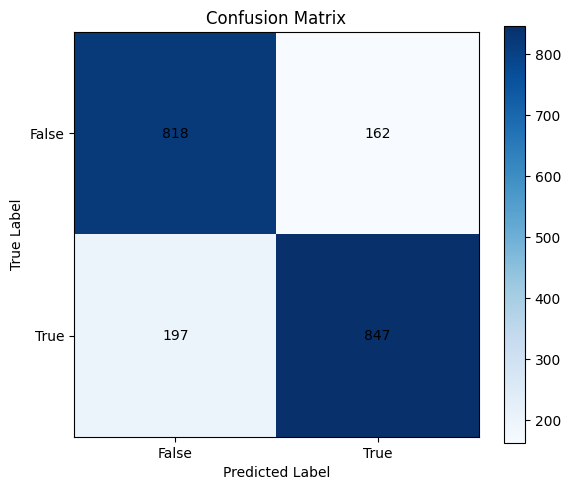


Training Accuracy: 0.8535
Difference (Train - Val): 0.0309
✅ No significant overfitting detected


In [21]:
# STEP 7: VALIDATION SPLIT EVALUATION
# ============================================
print("\n=== Final Validation ===")

# Hold-out validation using ORIGINAL (non-resampled) data
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_processed[rfe_selected], y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE only to training split (not validation!)
smote_val = SMOTE(random_state=42)
X_train_final_resampled, y_train_final_resampled = smote_val.fit_resample(X_train_final, y_train_final)

print(f"Training split after SMOTE: {len(y_train_final_resampled)} samples")
print(f"Validation split (original): {len(y_val)} samples")

# Train final model on training split
final_model.fit(X_train_final_resampled, y_train_final_resampled)

# Predict on validation (using original, non-resampled data)
y_val_pred = final_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"\nValidation Accuracy: {val_accuracy:.4f}")
print(f"Model used: {final_model_name}")

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_val, y_val_pred)
print(cm)

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['False', 'True'])
ax.set_yticklabels(['False', 'True'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

# Add text annotations
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# Check for overfitting
y_train_pred = final_model.predict(X_train_final_resampled)
train_accuracy = accuracy_score(y_train_final_resampled, y_train_pred)
print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Difference (Train - Val): {train_accuracy - val_accuracy:.4f}")

if train_accuracy - val_accuracy > 0.1:
    print("⚠️ WARNING: Possible overfitting detected!")
else:
    print("✅ No significant overfitting detected")



=== Making Test Predictions ===
Retraining XGBoost_tuned on full dataset...

Top 15 Feature Importances:
            Feature  Importance
4        TotalSpend    0.264577
5       SpendPerAge    0.160090
1    DrinkFoodRatio    0.094937
2     LogTotalSpend    0.083301
9             Vinyl    0.062224
19    PreferedAlbum    0.054334
14       TicketType    0.024198
10           Drinks    0.023358
6           LogFood    0.021898
0    FoodDrinkRatio    0.020589
24  OpinionPositive    0.018052
21          Concert    0.015840
26     TicketNumber    0.015490
3              Food    0.014000
8         LogDrinks    0.013961


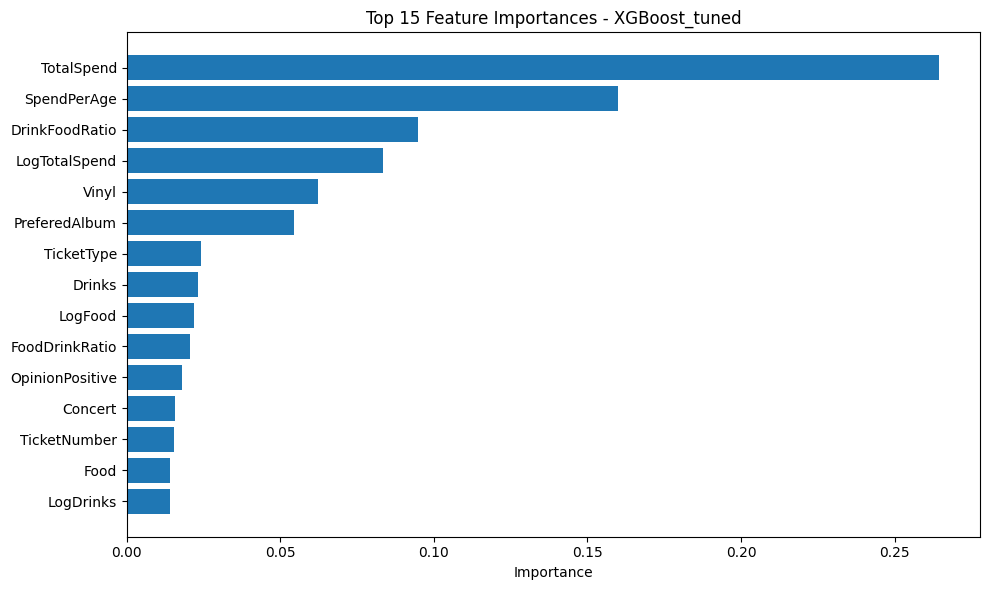


Prediction distribution:
True: 1424 (49.89%)
False: 1430 (50.11%)

Original training distribution:
True: 5216 (51.56%)
False: 4900 (48.44%)


In [22]:
# STEP 8: FINAL PREDICTIONS
# ============================================
print("\n=== Making Test Predictions ===")

# Retrain on ALL training data (with SMOTE)
print(f"Retraining {final_model_name} on full dataset...")
final_model.fit(X_train_selected, y_resampled)

# Feature importance analysis (if available)
if hasattr(final_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'Feature': rfe_selected,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 15 Feature Importances:")
    print(importance_df.head(15))
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df.head(15)['Feature'], importance_df.head(15)['Importance'])
    plt.gca().invert_yaxis()
    plt.title(f'Top 15 Feature Importances - {final_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
elif hasattr(final_model, 'named_estimators_'):  # For stacking
    print("\n📊 Stacking ensemble - checking base model importances...")
    for name, estimator in final_model.named_estimators_.items():
        if hasattr(estimator, 'feature_importances_'):
            importance_df = pd.DataFrame({
                'Feature': rfe_selected,
                'Importance': estimator.feature_importances_
            }).sort_values('Importance', ascending=False)
            print(f"\nTop 10 features for {name}:")
            print(importance_df.head(10))

# Make predictions
test_predictions = final_model.predict(X_test_selected)
test_predictions_bool = test_predictions.astype(bool)

print(f"\nPrediction distribution:")
print(f"True: {test_predictions_bool.sum()} ({test_predictions_bool.sum()/len(test_predictions_bool):.2%})")
print(f"False: {(~test_predictions_bool).sum()} ({(~test_predictions_bool).sum()/len(test_predictions_bool):.2%})")

# Compare to training distribution
print(f"\nOriginal training distribution:")
print(f"True: {y.sum()} ({y.sum()/len(y):.2%})")
print(f"False: {(~y.astype(bool)).sum()} ({(~y.astype(bool)).sum()/len(y):.2%})")


In [23]:
# STEP 9: CREATE SUBMISSION
# ============================================
submission = pd.DataFrame({
    'Id': test_ids,
    'FreePass': test_predictions_bool
})

# Save submission
filename = f'submission_{final_model_name.replace(" ", "_").lower()}.csv'
submission.to_csv(filename, index=False)
print(f"\n✅ Submission saved as '{filename}'")
print(f"Model used: {final_model_name}")
print(f"Validation accuracy: {val_accuracy:.4f}")

# Display sample
print("\n=== Sample Submission ===")
print(submission.head(10))

# Save model performance summary
summary = f"""
=== MODEL PERFORMANCE SUMMARY ===
Final Model: {final_model_name}
Validation Accuracy: {val_accuracy:.4f}
Training Accuracy: {train_accuracy:.4f}
Overfitting Gap: {train_accuracy - val_accuracy:.4f}

Features Used: {len(rfe_selected)}
Training Samples (after SMOTE): {len(y_resampled)}
Original Training Samples: {len(y)}

Predictions:
- True: {test_predictions_bool.sum()} ({test_predictions_bool.sum()/len(test_predictions_bool):.2%})
- False: {(~test_predictions_bool).sum()} ({(~test_predictions_bool).sum()/len(test_predictions_bool):.2%})
"""

print(summary)

# Save summary to file
with open('model_summary.txt', 'w') as f:
    f.write(summary)
print("\n📄 Model summary saved to 'model_summary.txt'")



✅ Submission saved as 'submission_xgboost_tuned.csv'
Model used: XGBoost_tuned
Validation accuracy: 0.8226

=== Sample Submission ===
        Id  FreePass
0  02/5375      True
1  01/6673     False
2  02/0337     False
3  01/6655      True
4  01/4723     False
5  01/3175      True
6  01/3024     False
7  01/8489      True
8  01/6525     False
9  01/6232      True

=== MODEL PERFORMANCE SUMMARY ===
Final Model: XGBoost_tuned
Validation Accuracy: 0.8226
Training Accuracy: 0.8535
Overfitting Gap: 0.0309

Features Used: 30
Training Samples (after SMOTE): 10432
Original Training Samples: 10116

Predictions:
- True: 1424 (49.89%)
- False: 1430 (50.11%)


📄 Model summary saved to 'model_summary.txt'


In [24]:
# STEP 10: VOTING ENSEMBLE OPTION 
# ============================================
print("\n=== Creating Voting Ensemble ===")

# Select top 5 performing models for ensemble
top_model_names = sorted(model_scores.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 models selected for ensemble:")
for name, score in top_model_names:
    print(f"  {name}: {score:.4f}")

# Create list of estimators for VotingClassifier
voting_estimators = []
for name, score in top_model_names:
    # Check if it's a tuned model
    if name.endswith('_tuned') and name.replace('_tuned', '') in tuned_models:
        voting_estimators.append((name, tuned_models[name.replace('_tuned', '')]))
        print(f"Added tuned {name}")
    elif name in trained_models:
        voting_estimators.append((name, trained_models[name]))
        print(f"Added base {name}")
    else:
        print(f"⚠️ Skipping {name} - model not found")

# Create VotingClassifier with soft voting (probability-based)
voting_clf = VotingClassifier(
    estimators=voting_estimators,
    voting='soft',
    n_jobs=-1
)

print(f"\nTraining voting ensemble with {len(voting_estimators)} models...")
voting_clf.fit(X_train_selected, y_resampled)

# Evaluate voting ensemble
voting_cv_scores = cross_val_score(voting_clf, X_train_selected, y_resampled,
                                   cv=3, scoring='accuracy', n_jobs=-1)

print(f"Voting Ensemble CV Accuracy: {voting_cv_scores.mean():.4f} (+/- {voting_cv_scores.std() * 2:.4f})")

# Compare to best individual model
best_individual = max(model_scores.items(), key=lambda x: x[1])
print(f"\nBest individual model: {best_individual[0]} with {best_individual[1]:.4f}")
print(f"Voting ensemble: {voting_cv_scores.mean():.4f}")
print(f"Improvement: {(voting_cv_scores.mean() - best_individual[1]):.4f}")

# Make predictions on test set
ensemble_predictions = voting_clf.predict(X_test_selected)
ensemble_predictions_bool = ensemble_predictions.astype(bool)

print(f"\nEnsemble prediction distribution:")
print(f"True: {ensemble_predictions_bool.sum()} ({ensemble_predictions_bool.sum()/len(ensemble_predictions_bool):.2%})")
print(f"False: {(~ensemble_predictions_bool).sum()} ({(~ensemble_predictions_bool).sum()/len(ensemble_predictions_bool):.2%})")

# Create ensemble submission
ensemble_submission = pd.DataFrame({
    'Id': test_ids,
    'FreePass': ensemble_predictions_bool
})

ensemble_submission.to_csv('submission_voting_ensemble.csv', index=False)
print("\n✅ Voting ensemble submission saved as 'submission_voting_ensemble.csv'")



=== Creating Voting Ensemble ===
Top 5 models selected for ensemble:
  XGBoost_tuned: 0.8160
  GradientBoosting: 0.8140
  XGBoost: 0.8126
  LightGBM_EarlyStopping: 0.8114
  LightGBM: 0.8112
Added tuned XGBoost_tuned
Added base GradientBoosting
Added base XGBoost
Added base LightGBM_EarlyStopping
Added base LightGBM

Training voting ensemble with 5 models...
Voting Ensemble CV Accuracy: 0.8137 (+/- 0.0031)

Best individual model: XGBoost_tuned with 0.8160
Voting ensemble: 0.8137
Improvement: -0.0023

Ensemble prediction distribution:
True: 1428 (50.04%)
False: 1426 (49.96%)

✅ Voting ensemble submission saved as 'submission_voting_ensemble.csv'


## Final Submission (Auto-Picked Model)
Run this cell last to ensure the submission is written using the best nested model and threshold picked on the hold-out split.


In [27]:
# Write final submission using best hold-out model/threshold (run after auto-pick cell)
# Requires: best_name, best_thr_final, best_model_final, X_test_selected, test_ids

# Fit on all training data
best_model_final.fit(X_nested, y_nested)
proba_test = best_model_final.predict_proba(X_test_selected)[:, 1]
preds_test = (proba_test >= best_thr_final).astype(bool)

submission_final = pd.DataFrame({
    'Id': test_ids,
    'FreePass': preds_test
})

filename_final = f"submission_final_{best_name.lower()}.csv"
submission_final.to_csv(filename_final, index=False)
print(f"✅ Final submission saved: {filename_final}")
print(f"Test positive rate: {preds_test.mean():.3f}")
print(f"Using model: {best_name} with threshold {best_thr_final:.2f} and accuracy {best_acc:.4f}")

✅ Final submission saved: submission_final_xgb_nested.csv
Test positive rate: 0.536
Using model: XGB_nested with threshold 0.46 and accuracy 0.8162


### How to improve accuracy:

Retrieving Notebook summary.

Here’s a safe plan to improve without overfitting or leakage:

- **Stay with the leak-safe pipeline** (the version without AvgTime). That’s your stable baseline (~0.82). Don’t use AvgTime-derived features.
- **Tune more, but conservatively**: rerun your XGBoost/LightGBM RandomizedSearch with slightly tighter ranges and +30–50 iterations; keep max_depth ≤ 6, min_child_weight ≥ 3, subsample/colsample 0.7–0.9, reg_alpha/reg_lambda > 0. Light learning rate (0.03–0.07) with 300–500 trees.
- **Use nested CV to avoid optimistic scores**: outer 5-fold for evaluation, inner 3-fold for tuning. This gives you a leak-free, low-variance estimate.
- **Calibrate probabilities, not just classes**: after fitting the best model, run `CalibratedClassifierCV` (cv=3, method='isotonic' or 'sigmoid') to improve decision thresholds; then choose the threshold that maximizes accuracy on a holdout/OOF.
- **Threshold tuning on OOF/val**: sweep thresholds (e.g., 0.35–0.65) using OOF preds from 5-fold CV; pick the best threshold, then train on full data and apply it to test probabilities.
- **Feature pruning**: keep the top ~30–50 features (you already RFE’d to 30). Try dropping the lowest-importance 5–10 features and re-evaluating; simpler models often generalize better.
- **Class-balance tweaks**: try SMOTE with sampling_strategy 0.7–0.9 (not full balance) or even no SMOTE with class_weight='balanced' in tree models; pick what wins on CV.
- **Regularization first**: prefer the “regularized” model settings you have (shallower trees, higher min_child_weight/min_samples_leaf, gamma>0 for XGB, min_child_samples for LGBM).
- **Ensembles, but small**: a simple soft-vote of your best 2–3 (e.g., tuned XGB + tuned LGBM + a regularized RF) often helps; avoid large stacks that can overfit.
- **Leak checks**: ensure all preprocessing (encoding, scaling, SMOTE) is fit only on training folds inside CV; align columns after fit/transform; avoid any feature computed with label info.

If you want, I can add two small helper cells: (1) nested-CV evaluation for XGB/LGBM, and (2) threshold sweep on OOF preds to pick the best cut point.